In [1]:
import glob 
import json
import spacy
import torch
import nltk
import warnings
import pickle
import numpy as np
import pandas as pd
from textblob import TextBlob
from scipy import spatial
from tqdm import tqdm
from bs4 import BeautifulSoup

en_nlp = spacy.load('en')
warnings.filterwarnings('ignore')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/shahebaz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def load_as_csv(path):
    paths_ =  []
    texts = []
    tf = pd.DataFrame()
    for filename in glob.iglob(str(path) + '*xml', recursive=True):
        paths_.append(filename)
    filenames = [x.split("/")[-1].split('.')[0] for x in paths_]
    tf['Name']  = filenames
    
    for filepath in tqdm(paths_):
        with open(filepath, encoding='utf-8') as fname:
            lines = fname.read()
            soup = BeautifulSoup(lines)
            text_list = []
            for i in soup.findAll({"formatting":"EnglishUnitedStates"}):
                text_list.append(i.text)
        texts.append(" ".join(text_list))

    tf['Text'] = texts
    return tf

In [3]:
train_df = load_as_csv("/home/shahebaz/SocGen/BrainWaves/data/train_data/")

100%|██████████| 249/249 [00:44<00:00,  5.09it/s]


In [4]:
train_df.head()

,Name,Text
0,sr23,(Multicurrency - Cross Border) ISDA Internatio...
1,95_sh,
2,al_9,(Multicurrency—Cross Border) ISDA Internationa...
3,aa_13,NEW YORK LAW EXECUTION COPY (Multicurrency- Cr...
4,cg_7,(Multicurrency - Cross Border) ISDA Internatio...


In [94]:
train_df[train_df['Name'] == '23_bk']

,Name,Text
38,23_bk,(Multicurrency — Cross Border) ISDA. Internati...


In [95]:
import numpy as np
import time

import torch
import torch.nn as nn

"""
BLSTM (max/mean) encoder
"""

class InferSent(nn.Module):

    def __init__(self, config):
        super(InferSent, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']
        self.version = 1 if 'version' not in config else config['version']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)

        assert self.version in [1, 2]
        if self.version == 1:
            self.bos = '<s>'
            self.eos = '</s>'
            self.max_pad = True
            self.moses_tok = False
        elif self.version == 2:
            self.bos = '<p>'
            self.eos = '</p>'
            self.max_pad = False
            self.moses_tok = True

    def is_cuda(self):
        # either all weights are on cpu or they are on gpu
        return self.enc_lstm.bias_hh_l0.data.is_cuda

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (bsize)
        # sent: (seqlen x bsize x worddim)
        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len_sorted, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent_len_sorted = sent_len_sorted.copy()
        idx_unsort = np.argsort(idx_sort)

        idx_sort = torch.from_numpy(idx_sort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_sort)
        sent = sent.index_select(1, idx_sort)

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len_sorted)
        sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]

        # Un-sort by length
        idx_unsort = torch.from_numpy(idx_unsort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_unsort)
        sent_output = sent_output.index_select(1, idx_unsort)

        # Pooling
        if self.pool_type == "mean":
            sent_len = torch.FloatTensor(sent_len.copy()).unsqueeze(1).cuda()
            emb = torch.sum(sent_output, 0).squeeze(0)
            emb = emb / sent_len.expand_as(emb)
        elif self.pool_type == "max":
            if not self.max_pad:
                sent_output[sent_output == 0] = -1e9
            emb = torch.max(sent_output, 0)[0]
            if emb.ndimension() == 3:
                emb = emb.squeeze(0)
                assert emb.ndimension() == 2

        return emb

    def set_w2v_path(self, w2v_path):
        self.w2v_path = w2v_path

    def get_word_dict(self, sentences, tokenize=True):
        # create vocab of words
        word_dict = {}
        sentences = [s.split() if not tokenize else self.tokenize(s) for s in sentences]
        for sent in sentences:
            for word in sent:
                if word not in word_dict:
                    word_dict[word] = ''
        word_dict[self.bos] = ''
        word_dict[self.eos] = ''
        return word_dict

    def get_w2v(self, word_dict):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with w2v vectors
        word_vec = {}
        with open(self.w2v_path, encoding='utf-8') as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if word in word_dict:
                    word_vec[word] = np.fromstring(vec, sep=' ')
        print('Found %s(/%s) words with w2v vectors' % (len(word_vec), len(word_dict)))
        return word_vec

    def get_w2v_k(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with k first w2v vectors
        k = 0
        word_vec = {}
        with open(self.w2v_path) as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if k <= K:
                    word_vec[word] = np.fromstring(vec, sep=' ')
                    k += 1
                if k > K:
                    if word in [self.bos, self.eos]:
                        word_vec[word] = np.fromstring(vec, sep=' ')

                if k > K and all([w in word_vec for w in [self.bos, self.eos]]):
                    break
        return word_vec

    def build_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        word_dict = self.get_word_dict(sentences, tokenize)
        self.word_vec = self.get_w2v(word_dict)
        print('Vocab size : %s' % (len(self.word_vec)))

    # build w2v vocab with k most frequent words
    def build_vocab_k_words(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        self.word_vec = self.get_w2v_k(K)
        print('Vocab size : %s' % (K))

    def update_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'warning : w2v path not set'
        assert hasattr(self, 'word_vec'), 'build_vocab before updating it'
        word_dict = self.get_word_dict(sentences, tokenize)

        # keep only new words
        for word in self.word_vec:
            if word in word_dict:
                del word_dict[word]

        # udpate vocabulary
        if word_dict:
            new_word_vec = self.get_w2v(word_dict)
            self.word_vec.update(new_word_vec)
        else:
            new_word_vec = []
        print('New vocab size : %s (added %s words)'% (len(self.word_vec), len(new_word_vec)))

    def get_batch(self, batch):
        # sent in batch in decreasing order of lengths
        # batch: (bsize, max_len, word_dim)
        embed = np.zeros((len(batch[0]), len(batch), self.word_emb_dim))

        for i in range(len(batch)):
            for j in range(len(batch[i])):
                embed[j, i, :] = self.word_vec[batch[i][j]]

        return torch.FloatTensor(embed)

    def tokenize(self, s):
        from nltk.tokenize import word_tokenize
        if self.moses_tok:
            s = ' '.join(word_tokenize(s))
            s = s.replace(" n't ", "n 't ")  # HACK to get ~MOSES tokenization
            return s.split()
        else:
            return word_tokenize(s)

    def prepare_samples(self, sentences, bsize, tokenize, verbose):
        sentences = [[self.bos] + s.split() + [self.eos] if not tokenize else
                     [self.bos] + self.tokenize(s) + [self.eos] for s in sentences]
        n_w = np.sum([len(x) for x in sentences])

        # filters words without w2v vectors
        for i in range(len(sentences)):
            s_f = [word for word in sentences[i] if word in self.word_vec]
            if not s_f:
                import warnings
                warnings.warn('No words in "%s" (idx=%s) have w2v vectors. \
                               Replacing by "</s>"..' % (sentences[i], i))
                s_f = [self.eos]
            sentences[i] = s_f

        lengths = np.array([len(s) for s in sentences])
        n_wk = np.sum(lengths)
        if verbose:
            print('Nb words kept : %s/%s (%.1f%s)' % (
                        n_wk, n_w, 100.0 * n_wk / n_w, '%'))

        # sort by decreasing length
        lengths, idx_sort = np.sort(lengths)[::-1], np.argsort(-lengths)
        sentences = np.array(sentences)[idx_sort]

        return sentences, lengths, idx_sort

    def encode(self, sentences, bsize=64, tokenize=True, verbose=False):
        tic = time.time()
        sentences, lengths, idx_sort = self.prepare_samples(
                        sentences, bsize, tokenize, verbose)

        embeddings = []
        for stidx in range(0, len(sentences), bsize):
            batch = self.get_batch(sentences[stidx:stidx + bsize])
            if self.is_cuda():
                batch = batch.cuda()
            with torch.no_grad():
                batch = self.forward((batch, lengths[stidx:stidx + bsize])).data.cpu().numpy()
            embeddings.append(batch)
        embeddings = np.vstack(embeddings)

        # unsort
        idx_unsort = np.argsort(idx_sort)
        embeddings = embeddings[idx_unsort]

        if verbose:
            print('Speed : %.1f sentences/s (%s mode, bsize=%s)' % (
                    len(embeddings)/(time.time()-tic),
                    'gpu' if self.is_cuda() else 'cpu', bsize))
        return embeddings

    def visualize(self, sent, tokenize=True):

        sent = sent.split() if not tokenize else self.tokenize(sent)
        sent = [[self.bos] + [word for word in sent if word in self.word_vec] + [self.eos]]

        if ' '.join(sent[0]) == '%s %s' % (self.bos, self.eos):
            import warnings
            warnings.warn('No words in "%s" have w2v vectors. Replacing \
                           by "%s %s"..' % (sent, self.bos, self.eos))
        batch = self.get_batch(sent)

        if self.is_cuda():
            batch = batch.cuda()
        output = self.enc_lstm(batch)[0]
        output, idxs = torch.max(output, 0)
        # output, idxs = output.squeeze(), idxs.squeeze()
        idxs = idxs.data.cpu().numpy()
        argmaxs = [np.sum((idxs == k)) for k in range(len(sent[0]))]

        # visualize model
        import matplotlib.pyplot as plt
        x = range(len(sent[0]))
        y = [100.0 * n / np.sum(argmaxs) for n in argmaxs]
        plt.xticks(x, sent[0], rotation=45)
        plt.bar(x, y)
        plt.ylabel('%')
        plt.title('Visualisation of words importance')
        plt.show()

        return output, idxs

"""
BiGRU encoder (first/last hidden states)
"""


class BGRUlastEncoder(nn.Module):
    def __init__(self, config):
        super(BGRUlastEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']

        self.enc_lstm = nn.GRU(self.word_emb_dim, self.enc_lstm_dim, 1,
                               bidirectional=True, dropout=self.dpout_model)

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: seqlen x batch x worddim

        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        _, hn = self.enc_lstm(sent_packed)
        emb = torch.cat((hn[0], hn[1]), 1)  # batch x 2*nhid

        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        emb = emb.index_select(0, torch.cuda.LongTensor(idx_unsort))

        return emb


"""
BLSTM encoder with projection after BiLSTM
"""


class BLSTMprojEncoder(nn.Module):
    def __init__(self, config):
        super(BLSTMprojEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)
        self.proj_enc = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, bias=False)

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple
        bsize = sent.size(1)

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        sent_output = self.enc_lstm(sent_packed)[0]
        # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]

        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        sent_output = sent_output.index_select(1, torch.cuda.LongTensor(idx_unsort))

        sent_output = self.proj_enc(sent_output.view(-1, 2*self.enc_lstm_dim)).view(-1, bsize, 2*self.enc_lstm_dim)
        # Pooling
        if self.pool_type == "mean":
            sent_len = torch.FloatTensor(sent_len).unsqueeze(1).cuda()
            emb = torch.sum(sent_output, 0).squeeze(0)
            emb = emb / sent_len.expand_as(emb)
        elif self.pool_type == "max":
            emb = torch.max(sent_output, 0)[0].squeeze(0)

        return emb


"""
LSTM encoder
"""


class LSTMEncoder(nn.Module):
    def __init__(self, config):
        super(LSTMEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=False, dropout=self.dpout_model)

    def forward(self, sent_tuple):
        # sent_len [max_len, ..., min_len] (batch)
        # sent (seqlen x batch x worddim)

        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        sent_output = self.enc_lstm(sent_packed)[1][0].squeeze(0)  # batch x 2*nhid

        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        emb = sent_output.index_select(0, torch.cuda.LongTensor(idx_unsort))

        return emb


"""
GRU encoder
"""


class GRUEncoder(nn.Module):
    def __init__(self, config):
        super(GRUEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim =  config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']

        self.enc_lstm = nn.GRU(self.word_emb_dim, self.enc_lstm_dim, 1,
                               bidirectional=False, dropout=self.dpout_model)

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)

        sent_output = self.enc_lstm(sent_packed)[1].squeeze(0)
        # batch x 2*nhid

        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        emb = sent_output.index_select(0, torch.cuda.LongTensor(idx_unsort))

        return emb


"""
Inner attention from "hierarchical attention for document classification"
"""


class InnerAttentionNAACLEncoder(nn.Module):
    def __init__(self, config):
        super(InnerAttentionNAACLEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']


        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1, bidirectional=True)

        self.proj_key = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, bias=False)
        self.proj_lstm = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, bias=False)
        self.query_embedding = nn.Embedding(1, 2*self.enc_lstm_dim)
        self.softmax = nn.Softmax()

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple
        bsize = sent.size(1)

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))
        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        sent_output = self.enc_lstm(sent_packed)[0]
        # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]
        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        sent_output = sent_output.index_select(1, torch.cuda.LongTensor(idx_unsort))

        sent_output = sent_output.transpose(0,1).contiguous()

        sent_output_proj = self.proj_lstm(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)

        sent_key_proj = self.proj_key(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)

        sent_key_proj = torch.tanh(sent_key_proj)
        # NAACL paper: u_it=tanh(W_w.h_it + b_w)  (bsize, seqlen, 2nhid)

        sent_w = self.query_embedding(torch.LongTensor(bsize*[0]).cuda()).unsqueeze(2) #(bsize, 2*nhid, 1)

        Temp = 2
        keys = sent_key_proj.bmm(sent_w).squeeze(2) / Temp

        # Set probas of padding to zero in softmax
        keys = keys + ((keys == 0).float()*-10000)

        alphas = self.softmax(keys/Temp).unsqueeze(2).expand_as(sent_output)
        if int(time.time()) % 100 == 0:
            print('w', torch.max(sent_w), torch.min(sent_w))
            print('alphas', alphas[0, :, 0])
        emb = torch.sum(alphas * sent_output_proj, 1).squeeze(1)

        return emb


"""
Inner attention inspired from "Self-attentive ..."
"""


class InnerAttentionMILAEncoder(nn.Module):
    def __init__(self, config):
        super(InnerAttentionMILAEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim =  config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1, bidirectional=True)

        self.proj_key = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, bias=False)
        self.proj_lstm = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, bias=False)
        self.query_embedding = nn.Embedding(2, 2*self.enc_lstm_dim)
        self.softmax = nn.Softmax()

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple
        bsize = sent.size(1)

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))
        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        sent_output = self.enc_lstm(sent_packed)[0]
        # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]
        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        sent_output = sent_output.index_select(1, torch.cuda.LongTensor(idx_unsort))

        sent_output = sent_output.transpose(0,1).contiguous()
        sent_output_proj = self.proj_lstm(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)
        sent_key_proj = self.proj_key(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)
        sent_key_proj = torch.tanh(sent_key_proj)
        # NAACL : u_it=tanh(W_w.h_it + b_w) like in NAACL paper

        # Temperature
        Temp = 3

        sent_w1 = self.query_embedding(torch.LongTensor(bsize*[0]).cuda()).unsqueeze(2) #(bsize, nhid, 1)
        keys1 = sent_key_proj.bmm(sent_w1).squeeze(2) / Temp
        keys1 = keys1 + ((keys1 == 0).float()*-1000)
        alphas1 = self.softmax(keys1).unsqueeze(2).expand_as(sent_key_proj)
        emb1 = torch.sum(alphas1 * sent_output_proj, 1).squeeze(1)


        sent_w2 = self.query_embedding(torch.LongTensor(bsize*[1]).cuda()).unsqueeze(2) #(bsize, nhid, 1)
        keys2 = sent_key_proj.bmm(sent_w2).squeeze(2) / Temp
        keys2 = keys2 + ((keys2 == 0).float()*-1000)
        alphas2 = self.softmax(keys2).unsqueeze(2).expand_as(sent_key_proj)
        emb2 = torch.sum(alphas2 * sent_output_proj, 1).squeeze(1)

        sent_w3 = self.query_embedding(torch.LongTensor(bsize*[1]).cuda()).unsqueeze(2) #(bsize, nhid, 1)
        keys3 = sent_key_proj.bmm(sent_w3).squeeze(2) / Temp
        keys3 = keys3 + ((keys3 == 0).float()*-1000)
        alphas3 = self.softmax(keys3).unsqueeze(2).expand_as(sent_key_proj)
        emb3 = torch.sum(alphas3 * sent_output_proj, 1).squeeze(1)

        sent_w4 = self.query_embedding(torch.LongTensor(bsize*[1]).cuda()).unsqueeze(2) #(bsize, nhid, 1)
        keys4 = sent_key_proj.bmm(sent_w4).squeeze(2) / Temp
        keys4 = keys4 + ((keys4 == 0).float()*-1000)
        alphas4 = self.softmax(keys4).unsqueeze(2).expand_as(sent_key_proj)
        emb4 = torch.sum(alphas4 * sent_output_proj, 1).squeeze(1)


        if int(time.time()) % 100 == 0:
            print('alphas', torch.cat((alphas1.data[0, :, 0],
                                       alphas2.data[0, :, 0],
                                       torch.abs(alphas1.data[0, :, 0] -
                                                 alphas2.data[0, :, 0])), 1))

        emb = torch.cat((emb1, emb2, emb3, emb4), 1)
        return emb


"""
Inner attention from Yang et al.
"""


class InnerAttentionYANGEncoder(nn.Module):
    def __init__(self, config):
        super(InnerAttentionYANGEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True)

        self.proj_lstm = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim,
                                   bias=True)
        self.proj_query = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim,
                                    bias=True)
        self.proj_enc = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim,
                                  bias=True)

        self.query_embedding = nn.Embedding(1, 2*self.enc_lstm_dim)
        self.softmax = nn.Softmax()

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple
        bsize = sent.size(1)

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))
        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        sent_output = self.enc_lstm(sent_packed)[0]
        # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]
        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        sent_output = sent_output.index_select(1, torch.cuda.LongTensor(idx_unsort))

        sent_output = sent_output.transpose(0,1).contiguous()

        sent_output_proj = self.proj_lstm(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)

        sent_keys = self.proj_enc(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)

        sent_max = torch.max(sent_output, 1)[0].squeeze(1)  # (bsize, 2*nhid)
        sent_summary = self.proj_query(sent_max).unsqueeze(1).expand_as(sent_keys)
        # (bsize, seqlen, 2*nhid)

        sent_M = torch.tanh(sent_keys + sent_summary)
        # (bsize, seqlen, 2*nhid) YANG : M = tanh(Wh_i + Wh_avg
        sent_w = self.query_embedding(torch.LongTensor(bsize*[0]).cuda()).unsqueeze(2)
        # (bsize, 2*nhid, 1)

        sent_alphas = self.softmax(sent_M.bmm(sent_w).squeeze(2)).unsqueeze(1)
        # (bsize, 1, seqlen)

        if int(time.time()) % 200 == 0:
            print('w', torch.max(sent_w[0]), torch.min(sent_w[0]))
            print('alphas', sent_alphas[0][0][0:sent_len[0]])
        # Get attention vector
        emb = sent_alphas.bmm(sent_output_proj).squeeze(1)

        return emb



"""
Hierarchical ConvNet
"""
class ConvNetEncoder(nn.Module):
    def __init__(self, config):
        super(ConvNetEncoder, self).__init__()

        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']

        self.convnet1 = nn.Sequential(
            nn.Conv1d(self.word_emb_dim, 2*self.enc_lstm_dim, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(inplace=True),
            )
        self.convnet2 = nn.Sequential(
            nn.Conv1d(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(inplace=True),
            )
        self.convnet3 = nn.Sequential(
            nn.Conv1d(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(inplace=True),
            )
        self.convnet4 = nn.Sequential(
            nn.Conv1d(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(inplace=True),
            )



    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple

        sent = sent.transpose(0,1).transpose(1,2).contiguous()
        # batch, nhid, seqlen)

        sent = self.convnet1(sent)
        u1 = torch.max(sent, 2)[0]

        sent = self.convnet2(sent)
        u2 = torch.max(sent, 2)[0]

        sent = self.convnet3(sent)
        u3 = torch.max(sent, 2)[0]

        sent = self.convnet4(sent)
        u4 = torch.max(sent, 2)[0]

        emb = torch.cat((u1, u2, u3, u4), 1)

        return emb


"""
Main module for Natural Language Inference
"""


class NLINet(nn.Module):
    def __init__(self, config):
        super(NLINet, self).__init__()

        # classifier
        self.nonlinear_fc = config['nonlinear_fc']
        self.fc_dim = config['fc_dim']
        self.n_classes = config['n_classes']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.encoder_type = config['encoder_type']
        self.dpout_fc = config['dpout_fc']

        self.encoder = eval(self.encoder_type)(config)
        self.inputdim = 4*2*self.enc_lstm_dim
        self.inputdim = 4*self.inputdim if self.encoder_type in \
                        ["ConvNetEncoder", "InnerAttentionMILAEncoder"] else self.inputdim
        self.inputdim = self.inputdim/2 if self.encoder_type == "LSTMEncoder" \
                                        else self.inputdim
        if self.nonlinear_fc:
            self.classifier = nn.Sequential(
                nn.Dropout(p=self.dpout_fc),
                nn.Linear(self.inputdim, self.fc_dim),
                nn.Tanh(),
                nn.Dropout(p=self.dpout_fc),
                nn.Linear(self.fc_dim, self.fc_dim),
                nn.Tanh(),
                nn.Dropout(p=self.dpout_fc),
                nn.Linear(self.fc_dim, self.n_classes),
                )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(self.inputdim, self.fc_dim),
                nn.Linear(self.fc_dim, self.fc_dim),
                nn.Linear(self.fc_dim, self.n_classes)
                )

    def forward(self, s1, s2):
        # s1 : (s1, s1_len)
        u = self.encoder(s1)
        v = self.encoder(s2)

        features = torch.cat((u, v, torch.abs(u-v), u*v), 1)
        output = self.classifier(features)
        return output

    def encode(self, s1):
        emb = self.encoder(s1)
        return emb


"""
Main module for Classification
"""


class ClassificationNet(nn.Module):
    def __init__(self, config):
        super(ClassificationNet, self).__init__()

        # classifier
        self.nonlinear_fc = config['nonlinear_fc']
        self.fc_dim = config['fc_dim']
        self.n_classes = config['n_classes']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.encoder_type = config['encoder_type']
        self.dpout_fc = config['dpout_fc']

        self.encoder = eval(self.encoder_type)(config)
        self.inputdim = 2*self.enc_lstm_dim
        self.inputdim = 4*self.inputdim if self.encoder_type == "ConvNetEncoder" else self.inputdim
        self.inputdim = self.enc_lstm_dim if self.encoder_type =="LSTMEncoder" else self.inputdim
        self.classifier = nn.Sequential(
            nn.Linear(self.inputdim, 512),
            nn.Linear(512, self.n_classes),
        )

    def forward(self, s1):
        # s1 : (s1, s1_len)
        u = self.encoder(s1)

        output = self.classifier(u)
        return output

    def encode(self, s1):
        emb = self.encoder(s1)
        return emb

In [6]:
train_df.iloc[79]

Name                                                  GN9
Text    (Multicurrency—Cross Border) ISDA Internationa...
Name: 79, dtype: object

In [96]:
paras = (train_df["Text"][38])

In [97]:
blob = TextBlob(paras)
sentences = [item.raw for item in blob.sentences]

In [98]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/shahebaz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [99]:
MODEL_PATH = 'encoder/infersent1.pickle'
params_model = {'bsize': 24, 'word_emb_dim': 300, 'enc_lstm_dim': 1024,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': 1}
infersent = InferSent(params_model)

In [100]:
infersent.set_w2v_path("./Glove/glove.840B.300d.txt")

In [101]:
infersent.build_vocab(sentences, tokenize=True)

Found 911(/956) words with w2v vectors
Vocab size : 911


In [102]:
dict_embeddings = {}
for i in range(len(sentences)):
    dict_embeddings[sentences[i]] = infersent.encode([sentences[i]], tokenize=True)

In [103]:
d1 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 0}

In [104]:
!ls ./data

dict_embeddings1.pickle


In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
texts_sentences = []
encodings = []
for text in tqdm(d1.keys()):
    texts_sentences.append(text)
    encodings.append(d1[text])

100%|██████████| 75/75 [00:00<00:00, 150874.24it/s]


In [107]:
tf = pd.DataFrame()
tf['text'] = texts_sentences
tf['embeddings'] = encodings

In [108]:
tf.head()

,text,embeddings
0,(Multicurrency — Cross Border) ISDA.,"[[0.04977842, 0.070655674, 0.0063406117, 0.088..."
1,"(""Party B"") Societe Generale (""Party A"") have ...","[[0.04730289, 0.070655674, 0.012730079, 0.0873..."
2,The terms defined in Section 14 and in the Sch...,"[[0.02222576, 0.070655674, -0.0013531125, 0.07..."
3,In the event of any inconsistency between the ...,"[[0.021477077, 0.070655674, 0.004618895, 0.072..."
4,Single Agreement.,"[[-0.009062683, 0.070655674, -0.006872487, 0.0..."


In [109]:
def cosine_sim(x, y ):
    return 1 - spatial.distance.cosine(x,y)

In [110]:
def levisian_distance(a, b):
    string1 = a
    string2 = b
    distance = 0
    n1 = len(string1)
    n2 = len(string2)
    if n1 >= n2:
        for i in range(n1):
            if i < n2:
                if string1[i] != string2[i]:
                    distance += 1
            else:
                distance += 1
    else:
        for i in range(n2):
            if i < n1:
                if string2[i] != string1[i]:
                    distance -= 1
            else:
                distance -= 1   
    return distance

In [111]:
def InferSentSim(field):
    cosine_similarities = []
    field_vector = infersent.encode([str(field)])
    for vec in tf['embeddings'].values:
        sim_score = cosine_sim(vec,field_vector)
        cosine_similarities.append(sim_score)
    tf['cosine_sim'] = cosine_similarities
    tf.sort_values(by='cosine_sim', ascending=False, inplace=True)
    return tf.reset_index(drop=True)

In [112]:
tf = InferSentSim("Termination Currency")
tf['len'] = tf['text'].apply(len)
tf.sort_values(by=['len','cosine_sim'], ascending=False, inplace=True)

In [113]:
tf['metric'] = tf['cosine_sim']/tf['len']

In [114]:
tf.sort_values(by=['metric'], ascending=True, inplace=True)

In [115]:
tf.reset_index(drop=True, inplace=True)

In [164]:
tf.head()

,text,embeddings,cosine_sim,len,metric
0,"(b) Party A Payee Tax Representations, (i) For...","[[0.06292498, 0.091146335, 0.022406401, 0.0688...",0.647552,799,0.000810
1,Subparagraph (ii) of Section 2(c) of this Agre...,"[[0.06871408, 0.08298866, 0.004530062, 0.06271...",0.663699,615,0.001079
2,"(c) ""Specified Indebtedness,"" with respect to ...","[[0.054371182, 0.106365345, 0.0053083343, 0.05...",0.654584,476,0.001375
3,In order to enable Party Y to exercise its rig...,"[[0.066733636, 0.14542283, 0.015501398, 0.0398...",0.643326,449,0.001433
4,(iii) Each obligation of each party under Sect...,"[[0.063484415, 0.08279579, -0.006872487, 0.058...",0.656880,439,0.001496


In [267]:
tf['text'].iloc[22]

'For each Transaction Party A and Party B agree to enter into under this Agreement, Party A shall use reasonable efforts to promptly send to Party B a Confirmation setting forth the terms of such Transaction.'

In [277]:
import matplotlib.pyplot as plt
%matplotlib inline

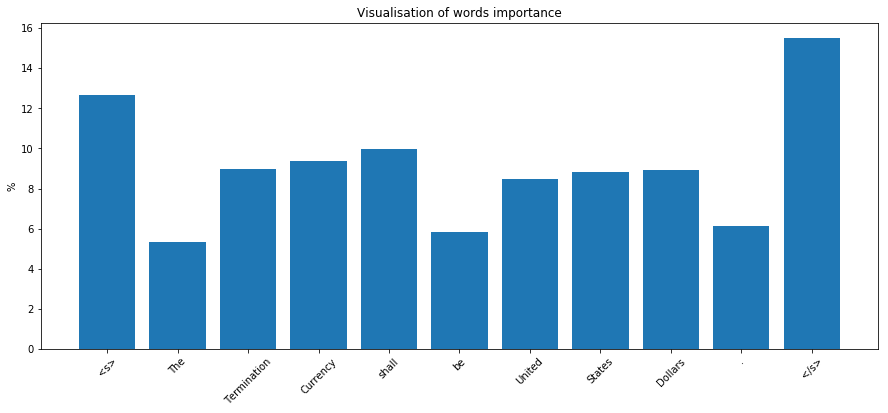

(tensor([[0.0546, 0.0707, 0.0038,  ..., 0.0328, 0.0729, 0.0100]],
        grad_fn=<MaxBackward0>), array([[3, 0, 2, ..., 3, 3, 1]]))

In [278]:
plt.figure(figsize=(15,6))
infersent.visualize(tf.iloc[48]['text'], tokenize=True)

## Gensim Sim Scores

In [117]:
import gensim
import nltk
import re
import pandas as pd
import numpy as np
import time
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from gensim.models import Word2Vec, doc2vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize

In [118]:
nltk.download('stopwords')
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shahebaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
import os
os.environ['PYTHONHASHSEED']= '0'

In [235]:
raw_body_corpus = []
for i, line in enumerate(sentences): 
    raw_body_corpus.append(TaggedDocument(gensim.utils.simple_preprocess(line), [i])) 

In [236]:
model_for_body = doc2vec.Doc2Vec(vector_size =10000, window=6,
                                               min_count=11, 
                                               epochs=2, alpha=.12)

In [237]:
model_for_body.build_vocab(raw_body_corpus)
model_for_body.train(raw_body_corpus, 
                     total_examples=model_for_body.corpus_count, 
                     epochs=100) 

In [238]:
def GetSolution(query):
    user_query = query
    user_body_vec = model_for_body.infer_vector(gensim.utils.simple_preprocess(user_query), steps=20)
    body_sims = model_for_body.docvecs.most_similar([user_body_vec], topn=20 ) 
    solutions = []
#     title_sols = []
    sim_score = []
    for i in body_sims:
        solutions.append(" ".join(raw_body_corpus[i[0]].words))
#         title_sols.append(" ".join(raw_title_corpus[i[0]].words)) 
        sim_score.append(i[1]) 
    solution_df = pd.DataFrame()
#     solution_df['Title'] = title_sols
    solution_df['Resolution'] = solutions
    solution_df['Sim Score'] = sim_score
    body_df = solution_df
    return body_df

In [239]:
test_df = GetSolution("Termination Currency means the")
for i in range(1,5):
    print(test_df['Resolution'][i])

termination provisions
the termination currency shall be united states dollars
payments on early termination
netting of payments


In [240]:
test_df = GetSolution("This Agreement will be goverened by ")
for i in range(1,5):
    print(test_df['Resolution'][i].title())

Waiver Of Right To Trial By Jury
Copyright By International Swap Dealers Association Inc Value Of That Which Was Or Would Have Been Required To Be Delivered As Of The Originally Scheduled Date For Delivery In Each Case Together With To The Extent Permitted Under Applicable Law Interest In The Currency Of Such Amounts From And Including The Date Such Amounts Or Obligations Were Or Would Have Been Required To Have Been Paid Or Performed To But Excluding Such Early Termination Date At The Applicable Rate
Netting Of Payments
The Commodity Derivatives Definitions The Commodity Commodity Definitions


In [244]:
test_df = GetSolution("The Date")
for i in range(1,5):
    print(test_df['Resolution'][i].title())

Name Title Date Name Title Date August Isda Execution Copy Border Schedule To The Master Agreement Dated As Of June Between And Societe Generale East North Interconnection Company Party Party Part
Hi Societe Generale East North Interconnection Company Ca Xjuuas Iat Ojuluvurri By Name Title Name Title
Societe Generale Name Of Party East North Jnterconnection Company Xtorwo Dorfr Cjloj Jb Mt Xnala Otl Ojrtt Ijjlucums By
In Witness Whereof The Parties Have Executed This Document On The Respective Dates Specified Below With Effect From The Date Specified On The First Page Of This Document


In [246]:
test_df = GetSolution("Termination Currency means the")
for i in range(1,5):
    print(test_df['Resolution'][i])

termination provisions
payments on early termination
the termination currency shall be united states dollars
iii each obligation of each party under section is subject to the condition precedent that no event of default or potential event of default with respect to the other party has occurred and is continuing the condition precedent that no early termination date in respect of the relevant transaction has occurred or been effectively designated and each other applicable condition precedent specified in this agreement


In [247]:
predicted_sentence = []
for i in range(1,5):
    predicted_sentence.append(test_df['Resolution'][i].title())

In [256]:
predicted_sentence = ''.join(predicted_sentence)

In [257]:
from nltk import Tree

en_nlp = spacy.load('en')
doc = en_nlp(predicted_sentence)
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

In [258]:
[to_nltk_tree(sent.root).pretty_print()  for sent in doc.sents]

ProvisionsPaymen
       ts       
       |         
  Termination   

                   On                                            
     ______________|_________                                     
    |                        Be                                  
    |         _______________|_______________________________     
    |        |     |                  Currency             States
    |        |     |          ___________|__________         |    
DollarsIii Early Shall TerminationThe          Termination United

     Obligation      
  _______|________    
 |                Of 
 |                |   
 |              Party
 |                |   
Each             Each

                                      Is                                
    __________________________________|____                              
   |            |                        Event                          
   |            |                 _________|________________________     
   |        

[None, None, None, None, None, None, None, None, None, None]

In [259]:
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [260]:
for sent in doc.sents:
    roots = [st.stem(chunk.root.head.text.lower()) for chunk in sent.noun_chunks]
    print(roots)

['provisionspay']
['be', 'be', 'on']
['oblig', 'of']
['und', 'to', 'of', 'default', 'of', 'with']
['to']
[]
['prec']
['dat']
['in', 'of']
['spec', 'in']


In [261]:
from spacy import displacy

In [262]:

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

United States 85 98 ORG
DollarsIii 99 109 ORG
Obligation Of Each Party 115 139 ORG
The Condition Precedent 168 191 ORG
Specified 494 503 NORP


In [263]:
from spacy import displacy

In [264]:
displacy.render(doc, style='dep',jupyter=True)

In [265]:
nlp = spacy.load('en')
displacy.render(doc, style='ent', jupyter=True)